# Math Tutor Assistant

## Objective

This notebook demonstrates the following:

- Showcases the foundational concepts of Assistants such as Threads, Messages, Runs, Tools, and lifecycle management.

This tutorial uses the following Azure AI services:

- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)\n",
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:

- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant).
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)
- [Github-OpenAI Python/examples/Assistant demo notebook](https://github.com/openai/openai-python/blob/main/examples/assistant.py)

## Time

You should expect to spend 5-10 minutes running this sample. 

## About this example

This sample shows users how to create an Azure OpenAI Assistant named "Math Tutor" using the Azure OpenAI API. The assistant is designed to function as a personal math tutor, capable of answering math questions through code interpretation. The script initiates a conversation with the assistant, guiding it through various mathematical queries and scenarios to showcase its capabilities.

This sample provides developers with a clear demonstration of how to leverage the core concepts of the Assistants API into their projects, highlighting its simplicity and effectiveness in leveraging foundational concepts. 

## Load the required libraries

In [44]:
#r "nuget: Azure.AI.OpenAI.Assistants, 1.0.0-beta.3"
#r "nuget: dotenv.net"

//#r "nuget: Microsoft.DotNet.Interactive.Formatting, 1.0.0-beta.24129.1"
//#r "nuget: SkiaSharp"

using Azure;
using Azure.AI.OpenAI.Assistants;

using System.Drawing;
using System.IO;
using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;
using Microsoft.DotNet.Interactive.Formatting;

Installed Packages Azure.AI.OpenAI.Assistants, 1.0.0-beta.3 dotenv.net, 3.1.3

## Load the environment variables

In [45]:
using dotenv.net;
DotEnv.Load(new DotEnvOptions(envFilePaths: new[] {"../.env"}));

var api_endpoint = Environment.GetEnvironmentVariable("OPENAI_URI");
var api_key = Environment.GetEnvironmentVariable("OPENAI_KEY");
var api_version = Environment.GetEnvironmentVariable("OPENAI_VERSION");
var api_deployment_name = Environment.GetEnvironmentVariable("OPENAI_GPT_DEPLOYMENT");


gpt4-1106-preview

### Create an Azure OpenAI client

In [46]:
AssistantsClient client = new AssistantsClient(new Uri(api_endpoint), new AzureKeyCredential(api_key));

In [47]:
Response<Assistant> assistantResponse = await client.CreateAssistantAsync(
    new AssistantCreationOptions(api_deployment_name)
    {
        Name = "Math Tutor",
        Instructions = "You are a personal math tutor. Write and run code to answer math questions.",
        Tools = { new CodeInterpreterToolDefinition() }        
    });
Assistant assistant = assistantResponse.Value;

### Create an Assistant and a Thread

In [48]:
Response<AssistantThread> threadResponse = await client.CreateThreadAsync();
AssistantThread thread = threadResponse.Value;

In [49]:
async Task<BinaryData> GetFileContent(string id)
{
    var fileContentResponse = await client.GetFileContentAsync(id);
    var fileContent = fileContentResponse.Value;
    return fileContent;
}

In [50]:
async Task ProcessMessagesAsync(IReadOnlyList<ThreadMessage> messages)
{
    List<ThreadMessage> localList = [];
    foreach (ThreadMessage threadMessage in messages)
    {
        localList.Add(threadMessage);
        if (threadMessage.Role == "user")
        {
            break;
        }
    }
    localList.Reverse();

    // Note: messages iterate from newest to oldest, with the messages[0] being the most recent
    foreach (ThreadMessage threadMessage in localList)
    {
        Console.Write($"{threadMessage.CreatedAt:yyyy-MM-dd HH:mm:ss} - {threadMessage.Role,10}: ");
        foreach (MessageContent contentItem in threadMessage.ContentItems)
        {
            if (contentItem is MessageTextContent textItem)
            {
                Console.Write(textItem.Text);
                var annotations = textItem.Annotations;
                if (annotations != null && annotations.Count > 0)
                {
                    foreach (var annotation in annotations)
                    {
                        if (annotation is MessageTextFileCitationAnnotation textCitation)
                        {
                            Console.Write(textCitation.Text);
                        }
                        else if (annotation is MessageTextFilePathAnnotation filCitation)
                        {
                            var content = await GetFileContent(filCitation.FileId);
                            if (content is not null)
                            {
                                Console.Write(Encoding.UTF8.GetString(content));
                            }
                        }
                    }
                }

            }
            else if (contentItem is MessageImageFileContent imageFileItem)
            {
                // Console.Write($"<image from ID: {imageFileItem.FileId}");
                var imageBytes = await GetFileContent(imageFileItem.FileId);
                if (imageBytes is not null)
                {
                    var b64 = Convert.ToBase64String(imageBytes);
                    var imgTag = $"<img src='data:image/png;base64,{b64}' />";
                    display(HTML(imgTag));
                }
            }
            Console.WriteLine();
        }
    }
}

In [51]:
async Task ProcessPrompt(string input)
{
    Response<ThreadMessage> messageResponse = await client.CreateMessageAsync(
        thread.Id,
        MessageRole.User,
        input);
    ThreadMessage message = messageResponse.Value;
    
    Response<ThreadRun> runResponse = await client.CreateRunAsync(thread,assistant);
    ThreadRun run = runResponse.Value;

    do
    {
        await Task.Delay(TimeSpan.FromMilliseconds(500));
        runResponse = await client.GetRunAsync(thread.Id, runResponse.Value.Id);
        if (runResponse.Value.Status == RunStatus.RequiresAction)
        {
            // Process Funcion calling
        }
    }
    while (runResponse.Value.Status == RunStatus.Queued
    || runResponse.Value.Status == RunStatus.InProgress);

    Response<PageableList<ThreadMessage>> afterRunMessagesResponse
    = await client.GetMessagesAsync(thread.Id);
    IReadOnlyList<ThreadMessage> messages = afterRunMessagesResponse.Value.Data;

    await ProcessMessagesAsync(messages);
}


### Have a conversation with the Assistant

In [52]:
await ProcessPrompt("What is the linear equation when two (x,y) points are (1,1) and (5,10)?");

2024-03-12 19:55:49 -       user: What is the linear equation when two (x,y) points are (1,1) and (5,10)?2024-03-12 19:56:05 -  assistant: The linear equation for the line passing through the points (1,1) and (5,10) is:

\[ y = 2.25x - 1.25 \]

In [53]:
await ProcessPrompt("I need to solve the equation `3x + 11 = 14`. Can you help me?");

2024-03-12 19:56:09 -       user: I need to solve the equation `3x + 11 = 14`. Can you help me?2024-03-12 19:56:18 -  assistant: The solution to the equation \(3x + 11 = 14\) is \(x = 1\).

2024-03-12 19:56:21 -       user: x=r*cos(u)sin(v), y=r*sin(u)sin(v), r=2+sin(7*u+5*v) for 0<u<2π and 0<v<π.
Create a graph of the equation z=r*cos(v).2024-03-12 19:56:43 -  assistant: 


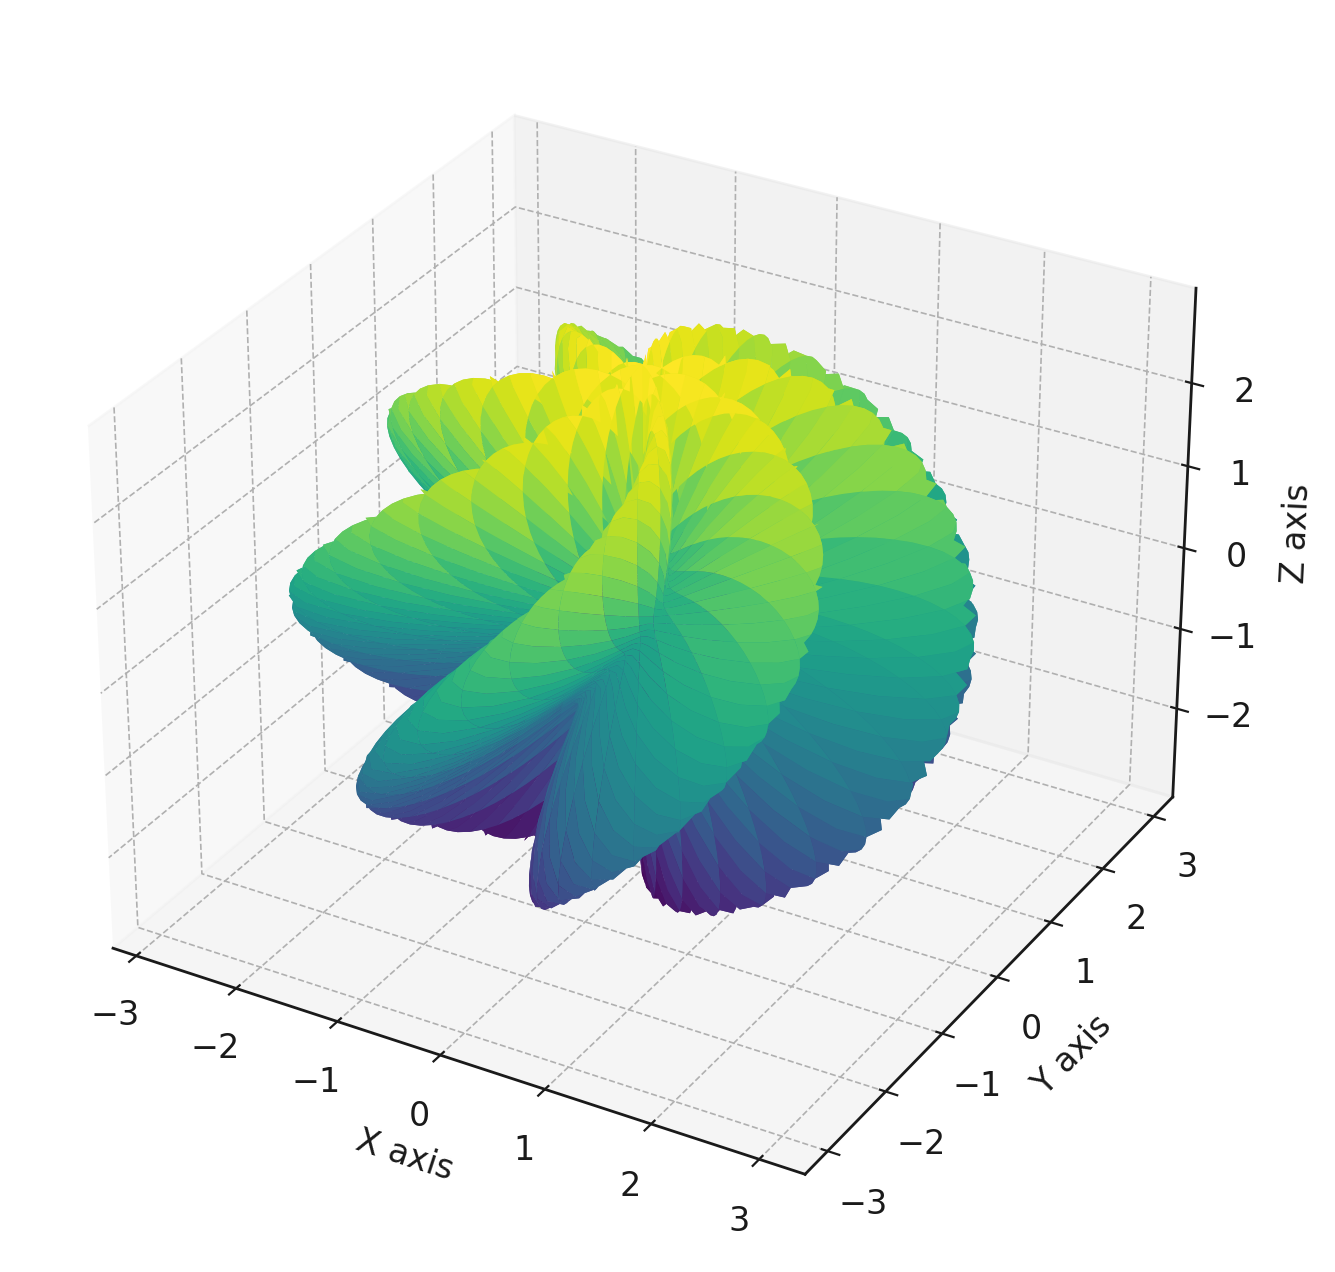

Here is the graph of the equation \( z = r \cos(v) \) using the given formula for \( r = 2 + \sin(7u + 5v) \) and ranges \( 0 < u < 2\pi \) and \( 0 < v < \pi \). The x and y coordinates are based on the equations \( x = r \cos(u) \sin(v) \) and \( y = r \sin(u) \sin(v) \). The surface is colored using the 'viridis' color map.

In [54]:
await ProcessPrompt(@"x=r*cos(u)sin(v), y=r*sin(u)sin(v), r=2+sin(7*u+5*v) for 0<u<2π and 0<v<π.
Create a graph of the equation z=r*cos(v).");

In [55]:
await ProcessPrompt("create a csv file with 10 customer names")

2024-03-12 19:56:56 -       user: create a csv file with 10 customer names2024-03-12 19:57:13 -  assistant: I have created a CSV file with 10 customer names. You can download it using the link below:

[Download customers.csv](sandbox:/mnt/data/customers.csv)Customer Name
Emma Williams
Olivia Brown
Liam Johnson
Noah Jones
Ava Garcia
Charlotte Miller
Sophia Davis
Mia Wilson
Amelia Taylor
Harper Anderson


### Cleanup

In [56]:
await client.DeleteAssistantAsync(assistant.Id);
await client.DeleteThreadAsync(thread.Id);